## 18 - Heterogeneous Treatment Effects and Personalization

Q1. Why are we passive when using the ML? and why are we now not passive with Causal inference?
Hint : $E[Y|X]$ and $E[Y|X, T]$
<br><br>
Answer : X is exogenous features like average sales in the previous week, information about the sales when T is the treatment we can intervene. Given X and T, we can optimize Y. Now, we have the control over the dataset with treatment. We can decide who we want to treat to reduce the variable of estimated Y. 
<br><br>
Q2. Now, we learned conditional average treatment effect(CATE) $E[Y_1−Y_0 | X] \ \text{or} \ E[y'(t)|X]$ and sensitivity (treatment effect by partition). 
<br><br>
    Q2-1) Why we cannot see sensitivity on a unit level?
    <br><br>
    Answer: Sensitivity is a slope coefficient of each group (i is group) $\frac{\delta Y}{ \delta T}_i$. Individual sensitivity per unit: Y changes with T. We need to have counterfactual piece because the slope can be calculated by estimating Y when T changes. But we don't know the T on both factual and counter factual.
    <br><br>
    Q2-2) $\frac{\delta Y_i}{ \delta T_i} \approx \frac{Y(T_i) - Y(T_i + \epsilon)}{T_i - (T_i + \epsilon)}$ Explain every component in the equation on the right side.
    <br><br>
    Answer : This is derivative of Y divided by derivative of T. The E represents the epsilon which is a tiny number. This means we are calculating the slope of Y over T on each unit.
    <br><br>
    Q2-3) How can we get sensitivity of each unit from regression?
    <br><br>
    Answer : $B1(treatment coef) + B2(X coefs)*X_i$ where X is our continuous treatment.
<br>
Practical Example with data set : 
Our goal is to find out having two door/
1. Split your dataset into train and test 70:30
2. Calculate the unit level sensitivity using coefs
3. Calculate sensitivity per unit using linear regression prediction and plot the sensitivity
4. Calculate sensitivity per unit using ridge, lasso, svm prediction and plot the sensitivity
5. Compare the result.

presentation.
Think about making prediction in ice cream sales. If you increase your price, you won't lose any sales but higher margin. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [2]:
prices_rnd = pd.read_csv("retail_price.csv")
print(prices_rnd.shape)
prices_rnd.head()

(676, 30)


,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [3]:
import re
# prices_rnd.loc[prices_rnd.]
prices_rnd = prices_rnd.loc[~prices_rnd.product_id.apply(lambda x:re.search('health',x)).isnull(),:].reset_index(drop=True).drop(columns=['product_id','product_category_name'])

In [4]:
prices_rnd['total_list_price'] = prices_rnd['freight_price']+prices_rnd['unit_price']

In [5]:
def get_prop(x):
    numerator_x = x['total_list_price'] - (
    (x['comp_1'] + x['fp1'] + x['comp_2'] + x['fp2'] + x['comp_3'] + x['fp3'])
                              )/3
    
    return numerator_x / x['total_list_price']

In [6]:
prices_rnd['diff_comp'] = prices_rnd.apply(lambda x: 
                 get_prop(x),axis=1
                )

In [7]:
prices_rnd

,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,...,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price,total_list_price,diff_comp
0,01-02-2017,11,219.89,11.750909,19.99,48,575,1,100,4.3,...,11.750909,19.990000,4.3,11.750909,64.990000,3.9,15.348000,19.94,31.740909,-0.510352
1,01-03-2017,9,179.91,13.818889,19.99,48,575,1,100,4.3,...,13.818889,89.990000,4.1,13.020000,64.990000,3.9,17.262222,19.99,33.808889,-1.159897
2,01-04-2017,13,259.87,18.038462,19.99,48,575,1,100,4.3,...,18.038462,19.990000,4.3,18.038462,64.990000,3.9,15.168889,19.99,38.028462,-0.369289
3,01-05-2017,16,319.84,14.847500,19.99,48,575,1,100,4.3,...,14.847500,89.990000,4.1,16.098333,64.990000,3.9,14.811875,19.99,34.837500,-1.111974
4,01-06-2017,21,419.79,12.683333,19.99,48,575,1,100,4.3,...,12.683333,89.990000,4.1,14.163333,58.799524,3.9,13.903333,19.99,32.673333,-1.137620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,01-04-2018,22,657.80,10.103182,29.90,55,388,1,250,4.5,...,10.103182,79.990000,4.1,14.485000,58.990000,3.9,16.302727,29.90,40.003182,-0.747952
126,01-05-2018,22,657.80,9.772727,29.90,55,388,1,250,4.5,...,7.988571,79.990000,4.1,21.943125,58.990000,3.9,9.422500,29.90,39.672727,-0.699944
127,01-06-2018,7,209.30,11.502857,29.90,55,388,1,250,4.5,...,16.270000,79.990000,4.1,13.362308,58.990000,3.9,16.430000,29.90,41.402857,-0.682914
128,01-07-2018,18,538.20,9.365556,29.90,55,388,1,250,4.5,...,18.810000,79.990000,4.1,16.745000,58.990000,3.9,7.670000,29.90,39.265556,-0.750432


<AxesSubplot:>

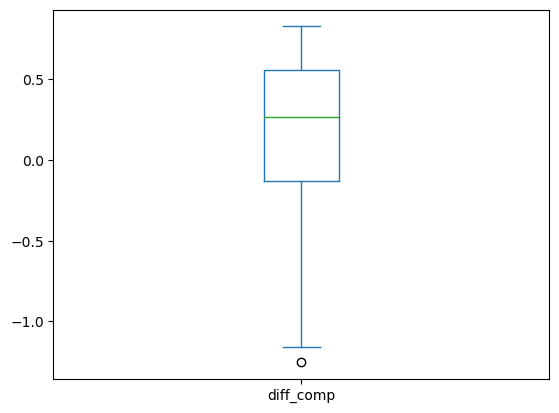

In [8]:
prices_rnd.diff_comp.plot.box()

In [9]:
t_list = ['diff_comp']
y_list = ['qty']
x_list = ['last_7avg','last_day','total_list_price','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_score','holiday']

In [10]:
prices_rnd['last_7avg'] = prices_rnd['qty'].rolling(window=7).mean().fillna(0)
prices_rnd['last_day'] =[0]+ prices_rnd['qty'][1:].to_list()

In [11]:
df = prices_rnd[y_list+x_list+t_list]

In [12]:
train, test = train_test_split(df,test_size=0.3)

In [13]:
m1 = smf.ols("qty ~ " + '+'.join(t_list)+' + '+'+'.join(x_list), data=train).fit()
m1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.4965,4.463,0.559,0.577,-6.385,11.378
diff_comp,3.2630,0.713,4.574,0.000,1.843,4.683
last_7avg,-0.0541,0.021,-2.600,0.011,-0.096,-0.013
last_day,0.9735,0.013,74.700,0.000,0.948,0.999
total_list_price,-0.0070,0.003,-2.733,0.008,-0.012,-0.002
product_name_lenght,-0.2740,0.059,-4.627,0.000,-0.392,-0.156
product_description_lenght,-0.0007,0.000,-1.931,0.057,-0.001,2.25e-05
product_photos_qty,0.3426,0.181,1.893,0.062,-0.018,0.703
product_weight_g,-0.0048,0.001,-4.299,0.000,-0.007,-0.003
product_score,3.8575,1.038,3.715,0.000,1.791,5.924


In [14]:
m2 = smf.ols("qty ~ diff_comp*last_day + total_list_price +last_day + last_7avg ", data=train).fit()
m2.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.0511,0.397,2.650,0.010,0.263,1.840
diff_comp,-1.1477,0.561,-2.047,0.044,-2.262,-0.033
last_day,0.9774,0.014,71.629,0.000,0.950,1.004
diff_comp:last_day,0.0591,0.025,2.404,0.018,0.010,0.108
total_list_price,-0.0003,0.002,-0.198,0.843,-0.004,0.003
last_7avg,-0.0377,0.019,-1.962,0.053,-0.076,0.001


In [15]:
def pred_sensitivity(m, df, t="diff_comp"):
    return df.assign(**{
        "pred_sens": m.predict(df.assign(**{t:df[t]+0.2})) - m.predict(df)
    })

pred_sens2 = pred_sensitivity(m2, test)
pred_sens2.head()

,qty,last_7avg,last_day,total_list_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,holiday,diff_comp,pred_sens
72,1,3.142857,1,379.200000,51,625,1,900,4.3,1,0.814971,-0.217724
33,26,17.285714,26,106.980385,59,492,3,250,4.1,4,0.320600,0.077802
95,19,18.142857,19,78.055263,59,492,2,200,3.9,2,0.053086,-0.004946
9,28,24.714286,28,36.365357,48,575,1,100,4.3,4,-0.998673,0.101444
70,4,3.571429,4,376.630000,51,625,1,900,4.3,1,0.804647,-0.182261


In [16]:
X = x_list+t_list
y = y_list
ml = GradientBoostingRegressor()
ml.fit(train[X], train[y])

# make sure the model is not overfiting.
ml.score(test[X], test[y])

/Users/tchun/opt/anaconda3/envs/carparts/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


0.9360647235283209

In [31]:
from sklearn.linear_model import Ridge,Lasso
from sklearn.svm import SVR

ms = SVR(epsilon=0.2)
ms.fit(train[X], train[y])
print(ms.score(test[X], test[y]))


mL = Lasso(alpha=1.0)
mL.fit(train[X], train[y])
print(mL.score(test[X], test[y]))


mr = Ridge(alpha=1.0)
mr.fit(train[X], train[y])
print(mr.score(test[X], test[y]))


-0.019235247079633977
0.9987804858194219
0.9959861872780232


/Users/tchun/opt/anaconda3/envs/carparts/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
mr.predict(pred_sens2[X]).squeeze().shape

(39,)

In [62]:
mL.predict(pred_sens2[X]).shape

(39,)

In [58]:
bands_df2.pred_band_mL

72     (1.2260000000000002, 13.104]
33                 (13.104, 56.575]
95                 (13.104, 56.575]
9                  (13.104, 56.575]
70     (1.2260000000000002, 13.104]
85     (1.2260000000000002, 13.104]
19     (1.2260000000000002, 13.104]
61                 (13.104, 56.575]
62                 (13.104, 56.575]
129                (13.104, 56.575]
17     (1.2260000000000002, 13.104]
12                 (13.104, 56.575]
94                 (13.104, 56.575]
16     (1.2260000000000002, 13.104]
55     (1.2260000000000002, 13.104]
128                (13.104, 56.575]
57     (1.2260000000000002, 13.104]
69     (1.2260000000000002, 13.104]
110    (1.2260000000000002, 13.104]
2                  (13.104, 56.575]
51                 (13.104, 56.575]
126                (13.104, 56.575]
114                (13.104, 56.575]
115                (13.104, 56.575]
96                 (13.104, 56.575]
81     (1.2260000000000002, 13.104]
28     (1.2260000000000002, 13.104]
47                 (13.104, 

In [76]:
bands_df2.pred_band_mr

72      (0.844, 12.661]
33     (12.661, 56.736]
95     (12.661, 56.736]
9      (12.661, 56.736]
70      (0.844, 12.661]
85      (0.844, 12.661]
19      (0.844, 12.661]
61     (12.661, 56.736]
62     (12.661, 56.736]
129     (0.844, 12.661]
17      (0.844, 12.661]
12     (12.661, 56.736]
94     (12.661, 56.736]
16      (0.844, 12.661]
55      (0.844, 12.661]
128    (12.661, 56.736]
57      (0.844, 12.661]
69      (0.844, 12.661]
110     (0.844, 12.661]
2      (12.661, 56.736]
51     (12.661, 56.736]
126    (12.661, 56.736]
114    (12.661, 56.736]
115    (12.661, 56.736]
96     (12.661, 56.736]
81      (0.844, 12.661]
28      (0.844, 12.661]
47     (12.661, 56.736]
118    (12.661, 56.736]
21     (12.661, 56.736]
127     (0.844, 12.661]
10     (12.661, 56.736]
119     (0.844, 12.661]
15      (0.844, 12.661]
31     (12.661, 56.736]
77      (0.844, 12.661]
75      (0.844, 12.661]
27      (0.844, 12.661]
66      (0.844, 12.661]
Name: pred_band_mr, dtype: category
Categories (2, interval[floa

In [68]:
pd.qcut(mr.predict(pred_sens2[X]).squeeze(), 2)
pd.qcut(
(mr.predict(pred_sens2[X]).squeeze())
    ,2)

[(0.844, 12.661], (12.661, 56.736], (12.661, 56.736], (12.661, 56.736], (0.844, 12.661], ..., (12.661, 56.736], (0.844, 12.661], (0.844, 12.661], (0.844, 12.661], (0.844, 12.661]]
Length: 39
Categories (2, interval[float64, right]): [(0.844, 12.661] < (12.661, 56.736]]

,qty,last_7avg,last_day,total_list_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,holiday,...,pred_sens,sens_band,pred_sales,pred_band,pred_sales_ms,pred_band_ms,pred_sales_mr,pred_sales_mL,pred_band_mL,pred_band_mr
72,1,3.142857,1,379.200000,51,625,1,900,4.3,1,...,-0.217724,"(-0.219, -0.0759]",1.337656,"(1.3370000000000002, 13.001]",11.214113,"(11.203000000000001, 12.804]",1.453522,1.227384,"(1.2260000000000002, 13.104]","(0.844, 12.661]"
33,26,17.285714,26,106.980385,59,492,3,250,4.1,4,...,0.077802,"(-0.0759, 0.456]",26.999604,"(13.001, 40.952]",13.145341,"(12.804, 13.526]",26.263319,25.742535,"(13.104, 56.575]","(12.661, 56.736]"
95,19,18.142857,19,78.055263,59,492,2,200,3.9,2,...,-0.004946,"(-0.0759, 0.456]",18.999827,"(13.001, 40.952]",13.265191,"(12.804, 13.526]",18.443957,19.013942,"(13.104, 56.575]","(12.661, 56.736]"
9,28,24.714286,28,36.365357,48,575,1,100,4.3,4,...,0.101444,"(-0.0759, 0.456]",27.999556,"(13.001, 40.952]",13.525862,"(12.804, 13.526]",28.269591,27.889316,"(13.104, 56.575]","(12.661, 56.736]"
70,4,3.571429,4,376.630000,51,625,1,900,4.3,1,...,-0.182261,"(-0.219, -0.0759]",3.999986,"(1.3370000000000002, 13.001]",11.219174,"(11.203000000000001, 12.804]",4.360228,4.129404,"(1.2260000000000002, 13.104]","(0.844, 12.661]"


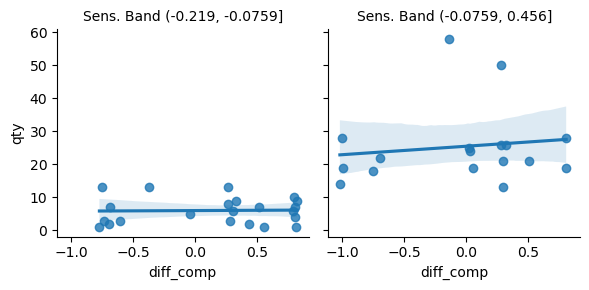

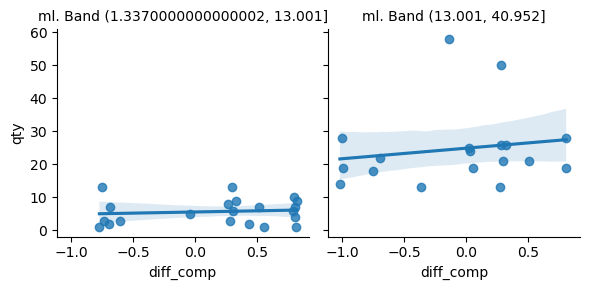

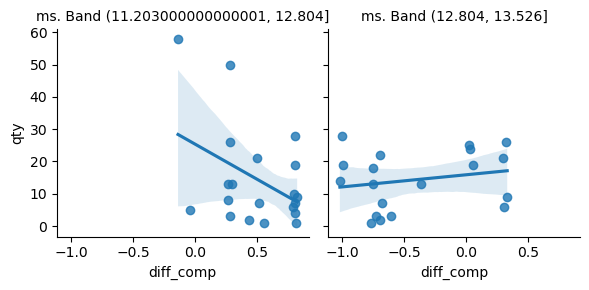

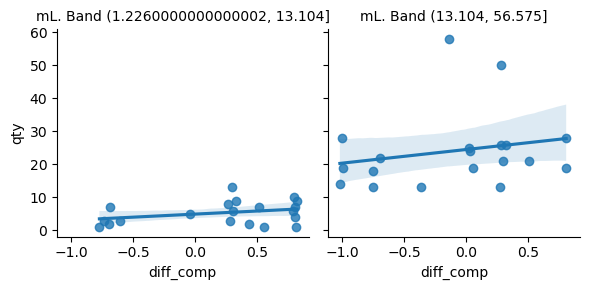

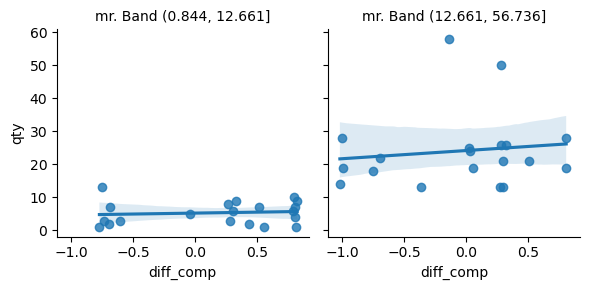

In [77]:


bands_df2 = pred_sens2.assign(
    sens_band = pd.qcut(pred_sens2["pred_sens"], 2), # create two groups based on sensitivity predictions 
    pred_sales = ml.predict(pred_sens2[X]),
    pred_band = pd.qcut(ml.predict(pred_sens2[X]), 2), # create two groups based on sales predictions

    pred_sales_ms = ms.predict(pred_sens2[X]),
    pred_band_ms = pd.qcut(ms.predict(pred_sens2[X]), 2), # create two groups based on sales predictions

    pred_sales_mr = mr.predict(pred_sens2[X]).squeeze(),
    # pred_band_mr = pd.qcut((mr.predict(pred_sens2[X]).squeeze()), 2), # create two groups based on sales predictions

    pred_sales_mL = mL.predict(pred_sens2[X]),
    pred_band_mL = pd.qcut(mL.predict(pred_sens2[X]), 2), # create two groups based on sales predictions
)


bands_df2['pred_band_mr']=pd.qcut(bands_df2['pred_sales_mr'],2)

g = sns.FacetGrid(bands_df2, col="sens_band")
g.map_dataframe(sns.regplot, x="diff_comp", y="qty")
g.set_titles(col_template="Sens. Band {col_name}");


g = sns.FacetGrid(bands_df2, col="pred_band")
g.map_dataframe(sns.regplot, x="diff_comp", y="qty")
g.set_titles(col_template="ml. Band {col_name}");

g = sns.FacetGrid(bands_df2, col="pred_band_ms")
g.map_dataframe(sns.regplot, x="diff_comp", y="qty")
g.set_titles(col_template="ms. Band {col_name}");

g = sns.FacetGrid(bands_df2, col="pred_band_mL")
g.map_dataframe(sns.regplot, x="diff_comp", y="qty")
g.set_titles(col_template="mL. Band {col_name}");

g = sns.FacetGrid(bands_df2, col="pred_band_mr")
g.map_dataframe(sns.regplot, x="diff_comp", y="qty")
g.set_titles(col_template="mr. Band {col_name}");

bands_df2.head()

In [20]:
#재밌군!